# Trabajo Final: Ejercicio 1

Este ejercicio consiste en trabajar sobre la primera parte del curso para extraer un modelo geométrico de una imagen.

Para este ejercicio vamos a trabajar sobre una imagen de una cancha de Fútbol.

Se probeen las funciones `draw_lines` y `draw_lines_polar` que les pueden servir para dibujar las rectas encontradas. 

\**En los ejercicios del trabajo final es posible utilizar funciones de librerias existentes o código sacado de internet. Siempre y cuando **no se usen para resolver explicitamente lo que pide el ejercicio** y al código sacado de interenet le agreguen el link en comentarios de donde fue sacado ese código.*

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from image_utils import draw_lines, draw_lines_polar
import progressbar
import random
from math import sqrt
import statistics as st


In [4]:
input_image = 'images/football.png'

### Load Input Image ###

In [5]:
image = cv2.imread(input_image,cv2.IMREAD_GRAYSCALE)/255

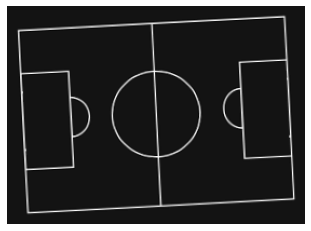

In [6]:
plt.imshow(image,cmap='gray')
plt.axis('off')
plt.show()

In [7]:
image_bgr = cv2.imread(input_image,cv2.IMREAD_COLOR)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

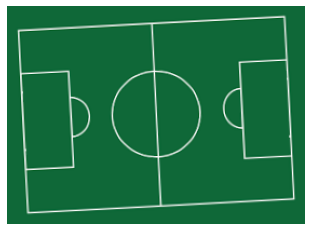

In [8]:
plt.imshow(image_rgb)
plt.axis('off')
plt.show()

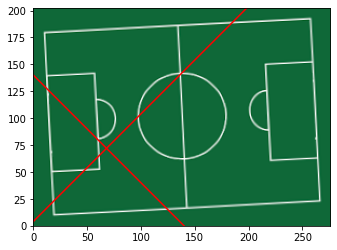

In [9]:
draw_lines(image_rgb,[[1,4],[-1,140]])

drawing rho 20 theta 120
drawing rho 100 theta 90


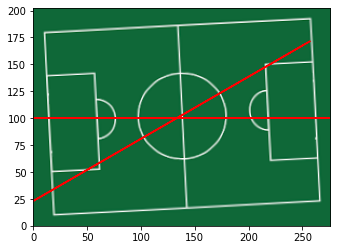

In [10]:
draw_lines_polar(image_rgb,[[20,120],[100,90]],theta_grad=True)

### Imágen de bordes ###

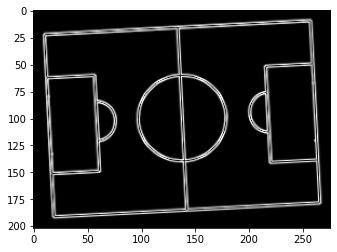

In [11]:
# Imágen a escala de grises 
img = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2GRAY)/255.

# Obtención de bordes
norm = cv2.normalize(img, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
filter_edge = np.array([-1,0,1]).reshape(1,3)
img_edge_h = cv2.filter2D(norm,-1, filter_edge.T)
img_edge_v = cv2.filter2D(norm, -1, filter_edge)

# Imágen de bordes (intensidad)
intensitity_image = np.sqrt(np.power(img_edge_h, 2) + np.power(img_edge_v,2))
plt.imshow(intensitity_image, cmap='gray', vmin=0, vmax=1)
plt.show()

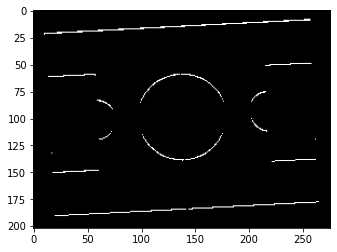

In [12]:
plt.imshow(img_edge_h, cmap='gray', vmin=0, vmax=1)
img_edge_h = img_edge_h > 0.5
plt.imshow(img_edge_h,cmap='gray', vmin=0, vmax=1)

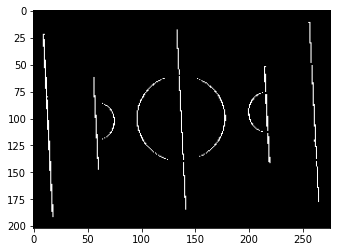

In [13]:
plt.imshow(img_edge_v, cmap='gray', vmin=0, vmax=1)
img_edge_v = img_edge_v > 0.5
plt.imshow(img_edge_v,cmap='gray', vmin=0, vmax=1)

In [14]:
def ransac_loop(image_points, points_subset, omega):
    # Estimar los parametros de la recta que pasan por points_subset
    (x1, y1) = points_subset[0]
    (x2, y2) = points_subset[1]
    inliners = 0
    """Hallar la recta que pasa por los dos puntos (pendiente-m y termino independiente-b)"""
    if x1 == x2:
        m = 0
        b = 0
    else:
        m = (y1-y2)/(x1-x2)
        b = (x1*y2 - x2*y1)/(x1-x2)
 
     # Contar cantidad de puntos de la imagen que "pasan" por la recta
    """Medimos la distancia desde todos los puntos blancos de la imagen de intensidad a la recta 
    y donde la distancia es menor a omega los consideramos como inliners """
    for (x3, y3) in image_points:
        d = np.abs(np.linalg.norm(np.cross((x2-x1, y2-y1), (x1-x3, y1-y3)))/np.linalg.norm((x2-x1, y2-y1)))
        if d <= omega:
            inliners+=1
   
    return [m,b, inliners, (x1,y1,x2,y2)]


def ransac(image, omega, N):
    
    # Transformar los puntos de la imágen con intensidad positiva en coordenadas
    image_points = []
    width = len(image[0])
    height = len(image)
    for y in range(0, height):
        for x in range(0, width):
            if image[y][x] > 0:
                image_points.append([x,height-y])

    # Iterar ransac_loop sobre todos los subsets de puntos
    possible_lines = []
    with progressbar.ProgressBar(max_value=N) as bar:
        for i in range(0, N):
            points_subset = [random.choice(image_points), random.choice(image_points)]
            line = ransac_loop(image_points, points_subset, omega)
            bar.update(i)
            if line[2] > 150 and line not in possible_lines: # Se toman en cuenta solo las rectas que tienen x o mas inliners a manera de filtro
                possible_lines.append(line)
    possible_lines = sorted(possible_lines, key=lambda x: x[2], reverse=True)
    return possible_lines

lines_h = ransac(img_edge_h, 1, 5000)
lines_v = ransac(img_edge_v, 1, 5000)


  0% (47 of 5000) |                      | Elapsed Time: 0:00:04 ETA:   0:07:32<ipython-input-14-2b2151333d39>:18: RuntimeWarning: invalid value encountered in double_scalars
  d = np.abs(np.linalg.norm(np.cross((x2-x1, y2-y1), (x1-x3, y1-y3)))/np.linalg.norm((x2-x1, y2-y1)))
100% (5000 of 5000) |####################| Elapsed Time: 0:07:45 Time:  0:07:45
100% (5000 of 5000) |####################| Elapsed Time: 0:08:47 Time:  0:08:47


### Non Max Suppression

<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


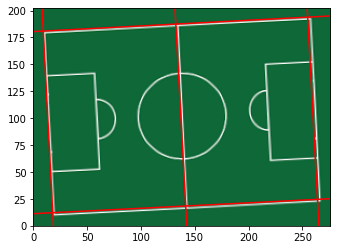

In [15]:
def lines_non_max_suppression (possible_lines):
    lines = [None, None, None, None, None]
    for line in possible_lines:
        if line[0] < 0 and line[1] < 500 and lines[0] is None:
            lines[0] = line
        elif line[0] < 0 and line[1] > 1000 and line[1] < 4000 and lines[1] is None:
            lines[1] = line
        elif line[0] < 0 and line[1] > 4000 and lines[2] is None:
            lines[2] = line
        elif line[0] > 0 and line[1] < 100 and lines[3] is None:
            lines[3] = line
        elif line[0] > 0 and line[1] > 100 and lines[4] is None:
            lines[4] = line
    return lines

lines = lines_non_max_suppression(np.concatenate((lines_h,lines_v)))

draw_lines(image_rgb,lines[:5])


### Puntos de intersección

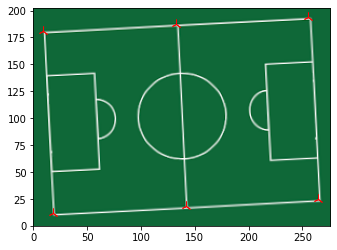

[array([-2602.46153846, 50325.46153846]),
 array([ -6500.42857143, 125166.42857143]),
 array([18.02287411, 12.16081718]),
 array([  9.23400765, 180.90705303]),
 array([-2602.46153846, 50325.46153846]),
 array([  13769., -249818.]),
 array([141.56056681,  18.38960841]),
 array([132.34255725, 187.38645038]),
 array([ -6500.42857143, 125166.42857143]),
 array([  13769., -249818.]),
 array([263.99660249,  24.56285391]),
 array([254.84680851, 193.83404255]),
 array([18.02287411, 12.16081718]),
 array([141.56056681,  18.38960841]),
 array([263.99660249,  24.56285391]),
 array([-76498.2,  -3845.8]),
 array([  9.23400765, 180.90705303]),
 array([132.34255725, 187.38645038]),
 array([254.84680851, 193.83404255]),
 array([-76498.2,  -3845.8])]

In [16]:
def lines_intersection(line1, line2):
    # https://stackoverflow.com/questions/44631259/line-line-intersection-in-python-with-numpy
    xa0, ya0, xa1, ya1 = line1[3]
    xb0, yb0, xb1, yb1 = line2[3]

    A = np.array([[xa0, ya0], [xa1, ya1]])
    B = np.array([[xb0, yb0], [xb1, yb1]])

    t, s = np.linalg.solve(np.array([A[1]-A[0], B[0]-B[1]]).T, B[0]-A[0])
    return((1-t)*A[0] + t*A[1])
   

def draw_intersections(lines):
    intersection_points = []
    for i in range(0,len(lines)):
        for j in range(0, len(lines)):  
            if i != j:
                intersection_points.append(lines_intersection(lines[i], lines[j]))
    draw_points(image_rgb, intersection_points)
    return intersection_points

def draw_points(image,points):
    fig, ax = plt.subplots()
    ax.imshow(image,  extent=[0, img.shape[1], 0, img.shape[0]])
    for x, y in points:
        ax.plot(x, y, marker='2', markersize=10, mec='r')
    ax.set_xlim(0,image.shape[1])
    ax.set_ylim(0,image.shape[0])
    plt.show()   


draw_intersections(lines)

In [21]:
### Ejercicio Bonus: Detección de Circulo

In [17]:

# https://www.geeksforgeeks.org/equation-of-circle-when-three-points-on-the-circle-are-given/
def findCircle(x1, y1, x2, y2, x3, y3) :
    x12 = x1 - x2;
    x13 = x1 - x3;
 
    y12 = y1 - y2;
    y13 = y1 - y3;
 
    y31 = y3 - y1;
    y21 = y2 - y1;
 
    x31 = x3 - x1;
    x21 = x2 - x1;
 
    # x1^2 - x3^2
    sx13 = pow(x1, 2) - pow(x3, 2);
 
    # y1^2 - y3^2
    sy13 = pow(y1, 2) - pow(y3, 2);
 
    sx21 = pow(x2, 2) - pow(x1, 2);
    sy21 = pow(y2, 2) - pow(y1, 2);
    if (2 * ((y31) * (x12) - (y21) * (x13))) == 0:
        f = 0
    else:

        f = (((sx13) * (x12) + (sy13) *
            (x12) + (sx21) * (x13) +
            (sy21) * (x13)) // (2 *
            ((y31) * (x12) - (y21) * (x13))));

    if (2 * ((x31) * (y12) - (x21) * (y13))) == 0:
        g = 0
    else:           
        g = (((sx13) * (y12) + (sy13) * (y12) +
            (sx21) * (y13) + (sy21) * (y13)) //
            (2 * ((x31) * (y12) - (x21) * (y13))));
    
    c = (-pow(x1, 2) - pow(y1, 2) -
         2 * g * x1 - 2 * f * y1);
 
    # eqn of circle be x^2 + y^2 + 2*g*x + 2*f*y + c = 0
    # where centre is (h = -g, k = -f) and
    # radius r as r^2 = h^2 + k^2 - c
    h = -g;
    k = -f;
    sqr_of_r = h * h + k * k - c;
 
    # r is the radius
    r = round(sqrt(sqr_of_r), 5);
    r = int(r)
    # print("Centre = (", h, ", ", k, ")");
    # print("Radius = ", r);
    
    return (h,k,r)
    
# https://stackoverflow.com/questions/19834528/what-is-the-distance-between-point-4-7-and-the-nearest-point-on-the-circle-ce
def dist(p, q):
       return sqrt((p[0] - q[0]) ** 2 + (p[1] - q[1]) ** 2)


def circle_ransac_loop (image_points, points_subset, omega):
    x1, y1 = points_subset[0]
    x2, y2 = points_subset[1]
    x3, y3 = points_subset[2]
    h, k, r = findCircle(x1, y1, x2, y2, x3, y3)
    inliners = 0

    for (px, py) in image_points: 
        d = dist([px, py], [h, k]) - r
        if d <= omega:
            inliners += 1
    return [h,k,r, inliners, (x1,y1,x2,y2,x3,y3)]



In [18]:

def ransac_circle(image, omega, N):
    
    # Transformar los puntos de la imágen con intensidad positiva en coordenadas
    image_points = []
    width = len(image[0])
    height = len(image)
    for y in range(0, height):
        for x in range(0, width):
            if image[y][x] > 0:
                image_points.append([x,height-y])

    # Iterar ransac_loop sobre todos los subsets de puntos
    possible_circles = []
    with progressbar.ProgressBar(max_value=N) as bar:
        for i in range(0, N):
            points_subset = [random.choice(image_points), random.choice(image_points), random.choice(image_points)]
            circle = circle_ransac_loop(image_points, points_subset, omega)
            bar.update(i)
            if circle[3] > 190 and circle not in possible_circles and circle[2] <45:
                possible_circles.append(circle)
    
    possible_circles = sorted(possible_circles, key=lambda x: x[3], reverse=True)
    return possible_circles



In [19]:
def circle_non_max_sup(circles):
    x = []
    y = []
    r = []
    for circle in circles:
        x.append(circle[0])
        y.append(circle[1])
        r.append(circle[2])
    
    return [st.mode(x), st.mode(y), st.mode(r)]

100% (100000 of 100000) |################| Elapsed Time: 0:03:02 Time:  0:03:02


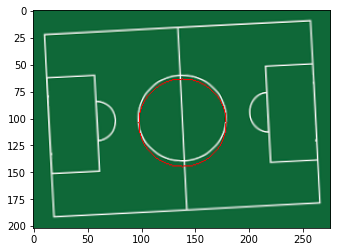

In [20]:
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

possible_circles = ransac_circle(img_edge_h, 0.5, 100000)
best_circle = circle_non_max_sup(possible_circles)

circles_image = cv2.circle(image_rgb, (best_circle[0],best_circle[1]), best_circle[2],(255,0,0), 1)
plt.imshow(circles_image)
plt.show()
